In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import numpy as np
from collections import Counter
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
training_df = pd.read_csv('../final_dataset.csv', index_col=0)
training_df = training_df.dropna()
ground_truth = training_df['Buy']
training_df = training_df.drop(['Symbol', 'beta', 'profitMargins','Name', 'Analyst', 'agora_pred'],
                          axis=1)
X = training_df[['headline_polarity', 'convo_polarity','forwardEps','bookValue', 'heldPercentInstitutions', 
        'shortRatio', 'shortPercentOfFloat']]
y = training_df['Buy']

X2 = training_df[['headline_polarity', 'convo_polarity','forwardEps','bookValue', 'heldPercentInstitutions', 
        'shortRatio', 'shortPercentOfFloat', 'last2PolarityDeltaConvo', 'last2PolarityDeltaHead','ConversationR2','HeadlinesR2','HeadlinePascal','ConversationPascal']]
y2 = training_df['Buy']

In [7]:
import os
num_comp = 13
scaler = StandardScaler()
pc = scaler.fit_transform(X2)

pca = PCA(n_components=num_comp)
pc = pca.fit_transform(pc)

components = pd.DataFrame(
    pca.components_,
    columns=X2.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

components.to_csv("pca_components_XTrain.csv", index=True)
print(len(components.columns.tolist()))
print(len(components.iloc[0].tolist()))

output_dir = "./PCGraphs"
os.makedirs(output_dir, exist_ok=True)

for i in range(num_comp):
    plt.figure(figsize=(10, 6))
    plt.bar(components.columns, components.iloc[i])  # change iloc to see different PC# 
    plt.title("Feature Contributions to PC" + str(i+1)) 
    plt.xlabel("Features")
    plt.ylabel("Contribution")
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Save the figure to the directory
    save_path = os.path.join(output_dir, f"PC{i+1}.png")
    plt.savefig(save_path)
    
    # Clear the current plot to avoid overlapping plots in the next iteration
    plt.close()

13
13


In [3]:
max_accuracy = -1
highest_accuracy_model = None
balanced_accuracy = -1
best_predictions = None

test_split = 0.20
best_y_test = None

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

y_train_distribution = Counter(y_train)
y_test_distribution = Counter(y_test)

print("\ny_train distribution:", y_train_distribution)
print("y_test distribution:", y_test_distribution)

y_train_percent = {k: v / len(y_train) * 100 for k, v in y_train_distribution.items()}
y_test_percent = {k: v / len(y_test) * 100 for k, v in y_test_distribution.items()}

print("\nClass distribution in y_train (percentages):", y_train_percent)
print("Class distribution in y_test (percentages):", y_test_percent)
print("\n")

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probs = model.predict_proba(X_test)

fp = (predictions == 1) & (y_test == 0)
fn = (predictions == 0) & (y_test == 1)

fp_indices = X_test.index[fp]
fn_indices = X_test.index[fn]

results_df = pd.DataFrame(X_test, columns=X.columns)
results_df['Actual'] = y_test
results_df['Predicted'] = predictions
results_df['Probability_Class_0'] = probs[:, 0]
results_df['Probability_Class_1'] = probs[:, 1]

results_fp_fn = results_df.loc[fp_indices.union(fn_indices)]

results_fp_fn.to_csv("fpfn.csv", index=False)

max_accuracy = sklearn.metrics.accuracy_score(predictions, y_test)
balanced_accuracy = balanced_accuracy_score(predictions, y_test)
highest_accuracy_model = model
best_predictions = predictions
best_y_test = y_test
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(log_loss(y_test, probs))
        
print(max_accuracy)
print(balanced_accuracy)

X_train size: (688, 7)
X_test size: (172, 7)
y_train size: (688,)
y_test size: (172,)

y_train distribution: Counter({1: 550, 0: 138})
y_test distribution: Counter({1: 127, 0: 45})

Class distribution in y_train (percentages): {1: 79.94186046511628, 0: 20.058139534883722}
Class distribution in y_test (percentages): {1: 73.83720930232558, 0: 26.16279069767442}


              precision    recall  f1-score   support

           0       0.82      0.51      0.63        45
           1       0.85      0.96      0.90       127

    accuracy                           0.84       172
   macro avg       0.83      0.74      0.77       172
weighted avg       0.84      0.84      0.83       172

[[ 23  22]
 [  5 122]]
0.5730003355906976
0.8430232558139535
0.8343253968253967


In [23]:
max_accuracy = -1
highest_accuracy_model = None
balanced_accuracy = -1
best_predictions = None

test_split = 0.20
best_y_test = None

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_split)

print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

y_train_distribution = Counter(y_train)
y_test_distribution = Counter(y_test)

print("\ny_train distribution:", y_train_distribution)
print("y_test distribution:", y_test_distribution)

y_train_percent = {k: v / len(y_train) * 100 for k, v in y_train_distribution.items()}
y_test_percent = {k: v / len(y_test) * 100 for k, v in y_test_distribution.items()}

print("\nClass distribution in y_train (percentages):", y_train_percent)
print("Class distribution in y_test (percentages):", y_test_percent)
print("\n")

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probs = model.predict_proba(X_test)

fp = (predictions == 1) & (y_test == 0)
fn = (predictions == 0) & (y_test == 1)

fp_indices = X_test.index[fp]
fn_indices = X_test.index[fn]

results_df = pd.DataFrame(X_test, columns=X2.columns)
results_df['Actual'] = y_test
results_df['Predicted'] = predictions
results_df['Probability_Class_0'] = probs[:, 0]
results_df['Probability_Class_1'] = probs[:, 1]

results_fp_fn = results_df.loc[fp_indices.union(fn_indices)]

results_fp_fn.to_csv("fpfn2.csv", index=False)

max_accuracy = sklearn.metrics.accuracy_score(predictions, y_test)
balanced_accuracy = balanced_accuracy_score(predictions, y_test)
highest_accuracy_model = model
best_predictions = predictions
best_y_test = y_test
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(log_loss(y_test, probs))
        
print(max_accuracy)
print(balanced_accuracy)

X_train size: (688, 13)
X_test size: (172, 13)
y_train size: (688,)
y_test size: (172,)

y_train distribution: Counter({1: 538, 0: 150})
y_test distribution: Counter({1: 139, 0: 33})

Class distribution in y_train (percentages): {1: 78.19767441860465, 0: 21.802325581395348}
Class distribution in y_test (percentages): {1: 80.81395348837209, 0: 19.186046511627907}


              precision    recall  f1-score   support

           0       0.88      0.64      0.74        33
           1       0.92      0.98      0.95       139

    accuracy                           0.91       172
   macro avg       0.90      0.81      0.84       172
weighted avg       0.91      0.91      0.91       172

[[ 21  12]
 [  3 136]]
0.30561017355125364
0.9127906976744186
0.8969594594594594


Original number of features: 13
Reduced number of features: 13
X_train size: (688, 13)
X_test size: (172, 13)
y_train size: (688,)
y_test size: (172,)

y_train distribution: Counter({1: 549, 0: 139})
y_test distribution: Counter({1: 128, 0: 44})

Class distribution in y_train (percentages): {1: 79.79651162790698, 0: 20.203488372093023}
Class distribution in y_test (percentages): {1: 74.4186046511628, 0: 25.581395348837212}


13
13


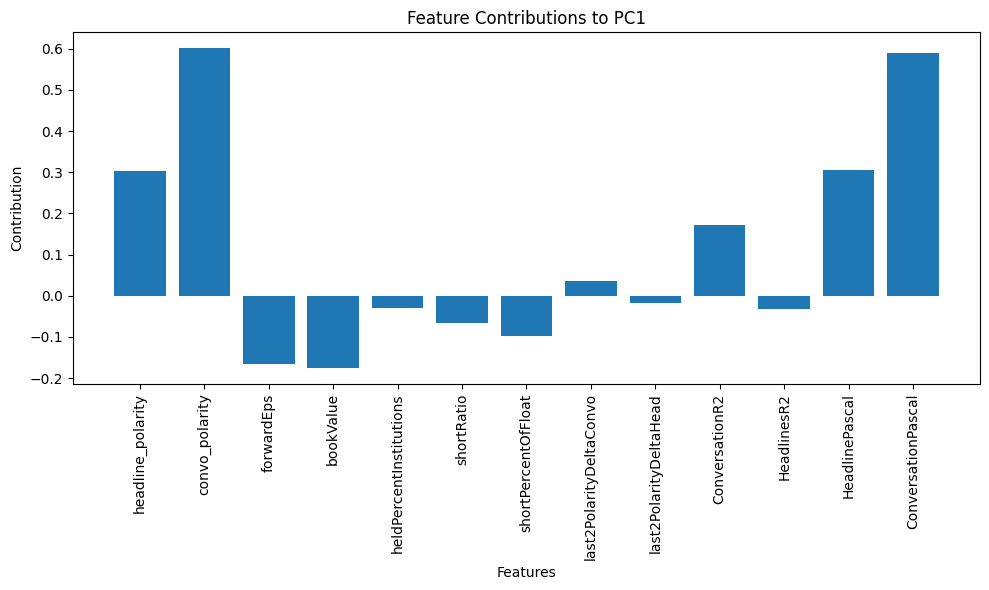

              precision    recall  f1-score   support

           0       0.95      0.43      0.59        44
           1       0.84      0.99      0.91       128

    accuracy                           0.85       172
   macro avg       0.89      0.71      0.75       172
weighted avg       0.86      0.85      0.83       172

[[ 19  25]
 [  1 127]]
0.612536848698002
0.8488372093023255
0.8927631578947368


In [3]:
#X2 with PCA
test_split = 0.20

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_split)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=13)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(f"Original number of features: {X2.shape[1]}")
print(f"Reduced number of features: {X_train.shape[1]}")

print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

y_train_distribution = Counter(y_train)
y_test_distribution = Counter(y_test)

print("\ny_train distribution:", y_train_distribution)
print("y_test distribution:", y_test_distribution)

y_train_percent = {k: v / len(y_train) * 100 for k, v in y_train_distribution.items()}
y_test_percent = {k: v / len(y_test) * 100 for k, v in y_test_distribution.items()}

print("\nClass distribution in y_train (percentages):", y_train_percent)
print("Class distribution in y_test (percentages):", y_test_percent)
print("\n")

components = pd.DataFrame(
    pca.components_,
    columns=X2.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Export PCA components to a CSV file
components.to_csv("pca_components_XTrain.csv", index=True)
print(len(components.columns.tolist()))
print(len(components.iloc[0].tolist()))

plt.figure(figsize=(10, 6))
plt.bar(components.columns, components.iloc[0]) # change iloc to see different PC#
plt.title("Feature Contributions to PC1")
plt.xlabel("Features")
plt.ylabel("Contribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probs = model.predict_proba(X_test)

fp = (predictions == 1) & (y_test == 0)
fn = (predictions == 0) & (y_test == 1)

fp_indices = np.where(fp)[0]
fn_indices = np.where(fn)[0]

X_test_df = pd.DataFrame(X_test, columns=[f"PC{i+1}" for i in range(X_test.shape[1])])

results_df = X_test_df.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = predictions
results_df['Probability_Class_0'] = probs[:, 0]
results_df['Probability_Class_1'] = probs[:, 1]

results_fp_fn = results_df.iloc[fp_indices.tolist() + fn_indices.tolist()]

results_fp_fn.to_csv("fpfn3.csv", index=False)

max_accuracy = sklearn.metrics.accuracy_score(predictions, y_test)
balanced_accuracy = balanced_accuracy_score(predictions, y_test)
highest_accuracy_model = model
best_predictions = predictions
best_y_test = y_test
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(log_loss(y_test, probs))
        
print(max_accuracy)
print(balanced_accuracy)

In [5]:
pickle.dump(highest_accuracy_model, open('RF_pickled_final_df.pkl', 'wb'))

In [37]:
#testing previous model and baseline models

"""import os
print(os.getcwd())"""
test_split = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

y_train_distribution = Counter(y_train)
y_test_distribution = Counter(y_test)

print("\ny_train distribution:", y_train_distribution)
print("y_test distribution:", y_test_distribution)

y_train_percent = {k: v / len(y_train) * 100 for k, v in y_train_distribution.items()}
y_test_percent = {k: v / len(y_test) * 100 for k, v in y_test_distribution.items()}

print("\nClass distribution in y_train (percentages):", y_train_percent)
print("Class distribution in y_test (percentages):", y_test_percent)
print("\n")

pickled_model = pickle.load(open('RF_pickled_final_old_df.pkl', 'rb'))
old_predictions = pickled_model.predict(X_test)
print("old model")
print(classification_report(y_test, old_predictions))
print(confusion_matrix(y_test, old_predictions))
print(log_loss(y_test, old_predictions))
print('accuracy: ', sklearn.metrics.accuracy_score(y_test, old_predictions))
print()

pickled_model = pickle.load(open('RF_pickled_final_old_df_defaultParam.pkl', 'rb'))
old_predictions = pickled_model.predict(X_test)
print("old default param model - not brute forced")
print(classification_report(y_test, old_predictions))
print(confusion_matrix(y_test, old_predictions))
print(log_loss(y_test, old_predictions))
print('accuracy: ', sklearn.metrics.accuracy_score(y_test, old_predictions))
print()

mostFreqBaseline = DummyClassifier(strategy="most_frequent")
mostFreqBaseline.fit(X_train, y_train)
mostFreqBaselinePred = mostFreqBaseline.predict(X_test)
print("most frequent baseline model")
print(classification_report(y_test, mostFreqBaselinePred, zero_division=0))
print(confusion_matrix(y_test, mostFreqBaselinePred))
print(log_loss(y_test, mostFreqBaselinePred))
print('accuracy: ', sklearn.metrics.accuracy_score(y_test, mostFreqBaselinePred))
print()

uniformBaseline = DummyClassifier(strategy="uniform")
uniformBaseline.fit(X_train, y_train)
uniformBaselinePred = uniformBaseline.predict(X_test)
print("uniform random baseline model")
print(classification_report(y_test, uniformBaselinePred))
print(confusion_matrix(y_test, uniformBaselinePred))
print(log_loss(y_test, uniformBaselinePred))
print('accuracy: ', sklearn.metrics.accuracy_score(y_test, uniformBaselinePred))
print()

stratifiedBaseline = DummyClassifier(strategy="stratified")
stratifiedBaseline.fit(X_train, y_train)
stratifiedBaselinePred = stratifiedBaseline.predict(X_test)
print("stratified random baseline model")
print(classification_report(y_test, stratifiedBaselinePred))
print(confusion_matrix(y_test, stratifiedBaselinePred))
print(log_loss(y_test, stratifiedBaselinePred))
print('accuracy: ', sklearn.metrics.accuracy_score(y_test, stratifiedBaselinePred))
print()

X_train size: (688, 7)
X_test size: (172, 7)
y_train size: (688,)
y_test size: (172,)

y_train distribution: Counter({1: 548, 0: 140})
y_test distribution: Counter({1: 129, 0: 43})

Class distribution in y_train (percentages): {1: 79.65116279069767, 0: 20.348837209302324}
Class distribution in y_test (percentages): {1: 75.0, 0: 25.0}


old model
              precision    recall  f1-score   support

           0       0.97      0.74      0.84        43
           1       0.92      0.99      0.96       129

    accuracy                           0.93       172
   macro avg       0.95      0.87      0.90       172
weighted avg       0.93      0.93      0.93       172

[[ 32  11]
 [  1 128]]
2.5146734922639875
accuracy:  0.9302325581395349

old default param model - not brute forced
              precision    recall  f1-score   support

           0       0.93      0.65      0.77        43
           1       0.89      0.98      0.94       129

    accuracy                           0.90  

In [78]:
pickled_model = pickle.load(open('RF_pickled_final_df.pkl', 'rb'))
new_predictions = pickled_model.predict(X_test)
print(classification_report(y_test, new_predictions))
print(confusion_matrix(y_test, new_predictions))
print(log_loss(y_test, new_predictions))
print('accuracy: ', sklearn.metrics.accuracy_score(new_predictions, y_test))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81        37
           1       0.92      0.99      0.96       135

    accuracy                           0.93       172
   macro avg       0.94      0.85      0.88       172
weighted avg       0.93      0.93      0.93       172

[[ 26  11]
 [  1 134]]
2.5146734922639875
accuracy:  0.9302325581395349


In [14]:
print(classification_report(best_y_test, best_predictions))

              precision    recall  f1-score   support

           0       0.90      0.64      0.75        14
           1       0.95      0.99      0.97       102

    accuracy                           0.95       116
   macro avg       0.93      0.82      0.86       116
weighted avg       0.95      0.95      0.94       116



In [23]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# model = RandomForestClassifier(n_estimators=6)
# model.fit(X_train, y_train)
# predictions = model.predict(X_test)
# print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.60      0.64        48
           1       0.89      0.92      0.90       170

    accuracy                           0.85       218
   macro avg       0.78      0.76      0.77       218
weighted avg       0.84      0.85      0.85       218



In [15]:
from xgboost import XGBClassifier

max_accuracy = -1
highest_accuracy_model = None
balanced_accuracy = -1
best_predictions = None

test_split_ll = 0.15
test_split_ul = 0.50
test_split = test_split_ll
best_y_test = None

while test_split <= test_split_ul:
    for i in range(1, 201):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
        #model = RandomForestClassifier(n_estimators=i)
        model = XGBClassifier(n_estimators=i)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        if sklearn.metrics.accuracy_score(predictions, y_test) > max_accuracy:
            max_accuracy = sklearn.metrics.accuracy_score(predictions, y_test)
            balanced_accuracy = max(balanced_accuracy, balanced_accuracy_score(predictions, y_test))
            highest_accuracy_model = model
            best_predictions = predictions
            best_y_test = y_test
            print(classification_report(y_test, predictions))
            print(confusion_matrix(y_test, predictions))
            print()
            print()
    
    test_split += 0.1
        
print(max_accuracy)
print(balanced_accuracy)

C:\Users\indox\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\indox\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\indox\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\indox\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: Undefine

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.81      1.00      0.90        94

    accuracy                           0.81       116
   macro avg       0.41      0.50      0.45       116
weighted avg       0.66      0.81      0.73       116

[[ 0 22]
 [ 0 94]]


              precision    recall  f1-score   support

           0       0.67      0.33      0.44        18
           1       0.89      0.97      0.93        98

    accuracy                           0.87       116
   macro avg       0.78      0.65      0.69       116
weighted avg       0.85      0.87      0.85       116

[[ 6 12]
 [ 3 95]]


              precision    recall  f1-score   support

           0       0.75      0.40      0.52        15
           1       0.92      0.98      0.95       101

    accuracy                           0.91       116
   macro avg       0.83      0.69      0.73       116
weighted avg       0.90      0.9